## Quantum Machine Learning Demo
Data obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) and sklearn 
 
This is the quantum comparison to the classical machine learning of the same data.

**PLEASE NOTE** Despite the upgrades, numpy==1.23 is required, as pposed to numpy 2.x
 
 

# Load Packages

In [1]:
from sklearn import datasets
# from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F


# from qiskit import QuantumCircuit
# from qiskit.algorithms.optimizers import SPSA
# from qiskit.circuit import ParameterVector,Parameter  # to set paramaters and multiple at once
# from qiskit.utils import QuantumInstance
# from qiskit.circuit.library import TwoLocal
# from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
# from qiskit_machine_learning.circuit.library import RawFeatureVector
# from qiskit_machine_learning.kernels import QuantumKernel
# from qiskit_machine_learning.neural_networks import CircuitQNN
# from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss


from IPython.display import clear_output
from PIL import Image

from sklearn.preprocessing import MinMaxScaler
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, Adam
from torch.utils.data import DataLoader, Dataset

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import z_feature_map, real_amplitudes
from qiskit_machine_learning.algorithms.classifiers import  NeuralNetworkClassifier, VQC
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN, NeuralNetwork
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.optimizers import COBYLA, SPSA

from qiskit.primitives import StatevectorEstimator as Estimator

C:\Users\meep_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.sparse import csr_matrix, issparse


# Load Data

In [2]:
data = datasets.load_breast_cancer()
x= data.data
y=data.target

# 212 M for malignant and 357 B for begnin, 0 --> 'M' and 1--> 'B'

df = pd.DataFrame(x)

# dataframe comes with unamed components, this labells them suchly

feature_names = data.feature_names
df.columns = feature_names

#Let's see how many components we have

print(len(df.columns))

df

30


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


As we see, our data set works with 30 components/observed variables, from our 569 cancer samples, that each could give unique insight into the outcome of cancer, or be completely extraneous. Some variables could even give key information, in relation to each other. 

Even though 30 isn't considered a lot in the context of machine learning, quantum machine learning often matches one variable to one qubit. There are only so many qubits in the quantum sphere, and for the sake of this demo, we will cut this down to 8 qubits and later run this on a quantum simulator for 8 qubits. For the kernel we choose later, we need to use a power of 2 for the number of qubits

To do this, we will peform [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), not before we normalize the data, to adjust for varying ranges in each component. Let's choose a [minmax scaler](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python).

In [3]:
scaler = MinMaxScaler()
scaler.fit(df)
scaler.data_max_
x_scaled = scaler.transform(df)

print(x_scaled, x) # for comparison

[[0.52103744 0.0226581  0.54598853 ... 0.91202749 0.59846245 0.41886396]
 [0.64314449 0.27257355 0.61578329 ... 0.63917526 0.23358959 0.22287813]
 [0.60149557 0.3902604  0.59574321 ... 0.83505155 0.40370589 0.21343303]
 ...
 [0.45525108 0.62123774 0.44578813 ... 0.48728522 0.12872068 0.1519087 ]
 [0.64456434 0.66351031 0.66553797 ... 0.91065292 0.49714173 0.45231536]
 [0.03686876 0.50152181 0.02853984 ... 0.         0.25744136 0.10068215]] [[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]


Now let's create a new data frame with our scaled data, encompassing PCA data

In [4]:
pca8 = PCA(8)

p_components = pca8.fit_transform(x_scaled)

names = []
for i in range(1, 9): # 0 based indexing, gives us pc1-pc8
    names.append("pc" + str(i))


pdf = pd.DataFrame(data= p_components, columns= names)

pdf

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8
0,1.387021,0.426895,-0.541703,0.048483,0.072198,0.190817,-0.236313,-0.039456
1,0.462308,-0.556947,-0.205175,-0.042830,-0.016111,0.015604,-0.043139,0.020644
2,0.954621,-0.109701,-0.147848,-0.001068,0.033798,0.069062,0.108166,0.007362
3,1.000816,1.525089,-0.053271,-0.207916,0.219381,0.388007,-0.194519,0.143499
4,0.626828,-0.302471,-0.409336,0.238811,0.002192,-0.157212,0.063308,0.045931
...,...,...,...,...,...,...,...,...
564,1.002840,-0.474785,-0.100041,0.272995,0.083888,-0.309121,0.129458,0.006007
565,0.620757,-0.517200,0.400360,0.182443,0.092984,-0.046000,0.083334,-0.111681
566,0.226311,-0.287946,0.315224,-0.011747,-0.218517,-0.080005,0.030991,0.015707
567,1.677834,0.335946,0.296116,-0.156305,-0.070204,0.109057,-0.068626,-0.092474


# Split Training and Test Data

In [5]:
pdf_array = np.array(pdf) #for the train_test_split()

#As is often standard,  the test suze will encompass 20% of our given data
x_train, x_test, y_train, y_test = train_test_split(pdf_array, y, test_size=0.20, random_state=5)


## Data Embedding

One of the most important facets of quantum machne learning is the kernel upon which you embed your data. In personal experience, I find a custom raw angle embedding feature map and corresponding kernel to be best. Let's define a function for our angle embedding feature map.

In [6]:
def angle_embedding(num_features):
       
    """
    Returns a quantum circuit consisting of x rotations to function as a feature map, encompassing of any num_features (int)
    Where the x rotations will later correspond to the data

    : qc: The quantum circuit.
    : num_features: The number of features of the feature vector. (AKA the number of pricnipal components)
  
    """
    assert num_features 
    
    x_params = ParameterVector("theta", num_features) #"x" is a generic label, useful for denotating as x rotations
    qc = QuantumCircuit(num_features)

    for i in range(num_features):
        qc.rx(x_params[i], i)
        
    return qc

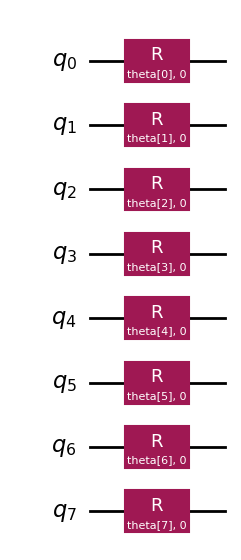

In [7]:
num_features = len(x_train[0]) # number of principal components

feature_map = angle_embedding(num_features)

feature_map.decompose().draw('mpl')

As you can see, we have succesfully created a basic feature map to embed the values from our training data into a kernel. Let's add an anzatz with random 

## Ansatz
Here we will create an anzatz to append on this circuit as a way of weighting qubits and taking advantage of Hilbert space, by encoporating y ansd z rotations. We will use a [z_feature_map](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.z_feature_map), heuristic which we will assign random weights to, which will be adjusted during training.  

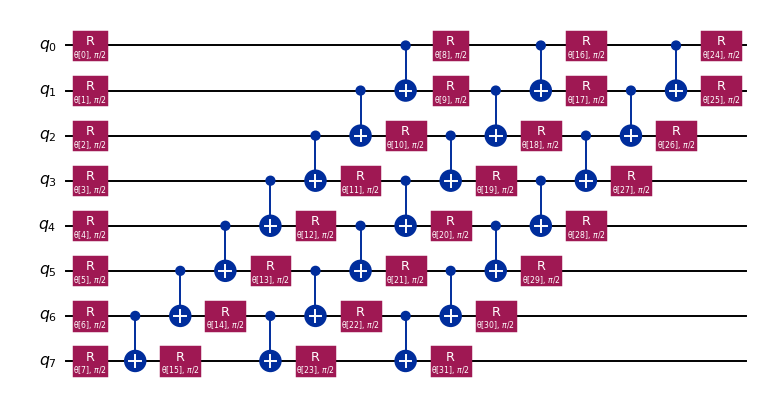

In [8]:
dimensions = len(x_train[0])

ansatz_ra = real_amplitudes(dimensions)
ansatz_ra.decompose().draw('mpl', scale=0.7)

## Sampler
As we are classifying malignant vs benign cell samples, we can classify this with a binary output, which we will need to tell our circuit quantum neural network function. First we will try a simpler Smpler class

In [9]:
# Create Novel QC base
qc = QuantumCircuit(dimensions)
# Compose with Feature MAp and Ansatz
qc.compose(feature_map, inplace= True)
qc.compose(ansatz_ra, inplace = True)

from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()

# Binary Parity
parity = lambda x: "{:b}".format(x).count("1") % 2  

qnn1 = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz_ra.parameters,
    interpret = parity,
    output_shape = 2,
    sampler=sampler,
)
num_classes = 2



# # We assigned weights randomly, to tweak later on
# weights = np.random.random(len(ansatz_ra.parameters))
# model1 = TorchConnector(qnn1, weights)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


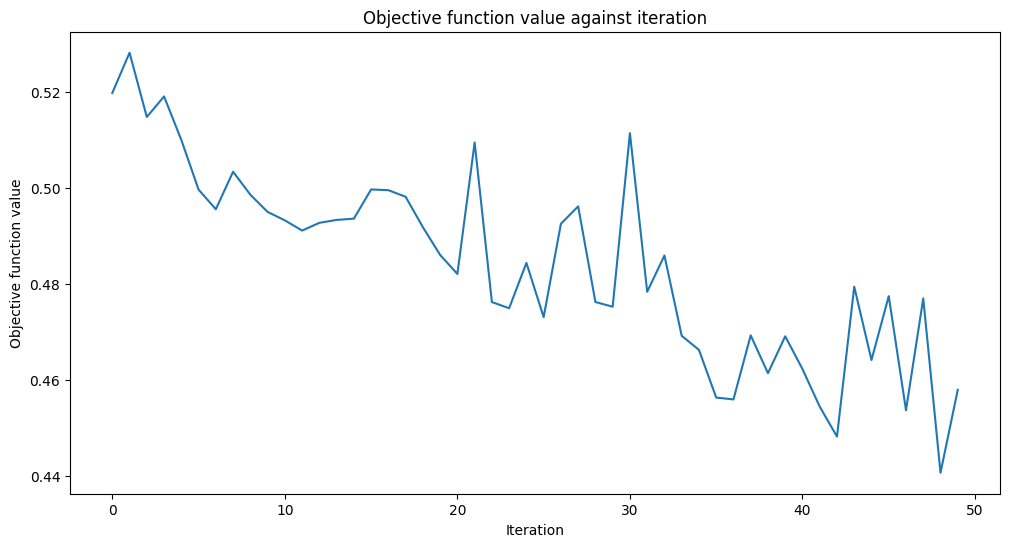

Train Accuracy Score 0.6395604395604395
Test Accuracy Score 0.5789473684210527


In [10]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

sampler_classifier = NeuralNetworkClassifier(
    neural_network=qnn1, optimizer=COBYLA(maxiter=50), callback=callback_graph
)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(x_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print(f"Train Accuracy Score {sampler_classifier.score(np.array(x_train), np.array(y_train))}")
print(f"Test Accuracy Score {sampler_classifier.score(np.array(x_test), np.array(y_test))}")

Despite th proof of trainig, not great scores, let's try something else

# VQC

Now that we have built our circuits and checked STUFF, let compare the basic Sampler class to the Variational Quantum Classifier (VQC) . One of the easiest ways to do this is with a Variation Quantum Classifier (VQC). 

First we'll create a function tocreate a callback functrion taht allows us to make a callbackgraph to visualize objective function value over iterations, to ensure that training is occuring

In [11]:
def callback(weights, obj_func_eval):
    """
    Create a callback graph to track objective function value over iteration

    Returns: None Function to be passed into callback function
    """
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

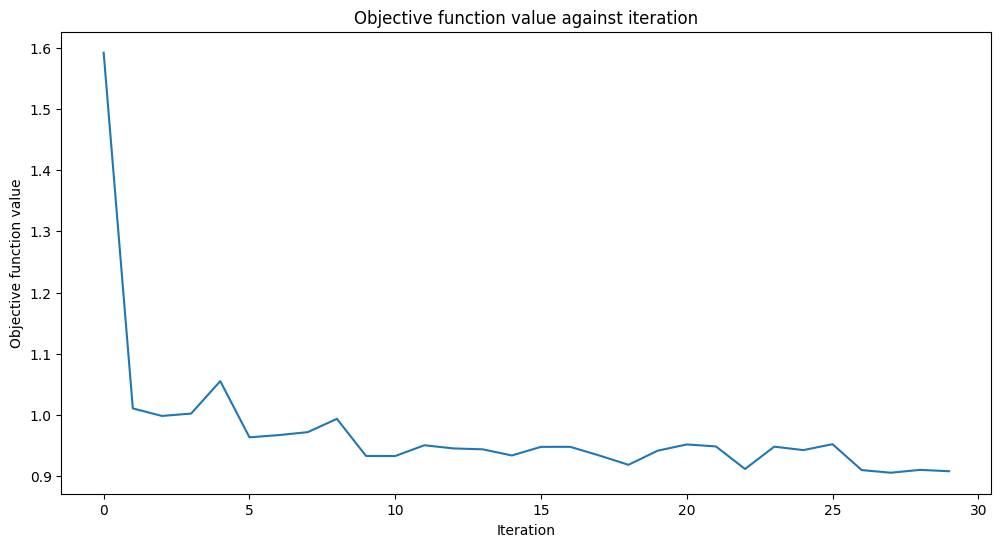

VQC Test Accuracy = 0.6483516483516484
VQC Test Accuracy = 0.6052631578947368


In [12]:
vqc = VQC(
        feature_map=feature_map,
        ansatz=ansatz_ra,
        loss="cross_entropy",
        optimizer=COBYLA(maxiter= 30),
        callback=callback_graph,
        sampler=sampler,
    )

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(x_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)


train_acc= vqc.score(x_train, y_train)
print(f"VQC Test Accuracy = {train_acc}")
test_acc= vqc.score(x_test, y_test)
print(f"VQC Test Accuracy = {test_acc}")

Also not great, so let's try something deeper

## HybridQNN

Now let's build a Hyprid QNN with PyTorch for a more complex task to see ho well it does

In [13]:
estimator = Estimator()

qnn2 = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz_ra.parameters,
        input_gradients=True,
        estimator=estimator,
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [14]:
# Resplit data without PCs
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.20, random_state=5)
# Process as tensors for training downstream
class bc_dataset(Dataset):
    def __init__(self, x_array, y_array):
        self.x = Tensor(x_array)
        self.y= Tensor(y_array).long()

    def __len__(self):
        return len(self.x)

    def __getitem__(self,idx):
        return self.x[idx], self.y[idx]


train_dataset = bc_dataset(x_train, y_train)
test_dataset = bc_dataset(x_test, y_test)


batch_size = 1
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
class Net(nn.Module):
    def __init__(self, qnn, num_features,fm_params):
        super().__init__()
        self.fc1 = nn.Linear(num_features,16) 
        self.fc2 = nn.Linear(16,fm_params)
        self.qnn = TorchConnector(qnn)
        self.fc3 = nn.Linear(1, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)
        x = self.fc3(x)
        return torch.cat((x, 1 - x), -1)

dimensions = len(x_train[0])
fm_params = len(feature_map.parameters)

model = Net(qnn2, dimensions, fm_params)

In [16]:
optimizer = Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print(f"Training Epoch {epoch}", loss_list[-1])

Training Epoch 0 -0.6286576573174079
Training Epoch 1 -1.0252363790960082
Training Epoch 2 -1.6050155028537079
Training Epoch 3 -2.1183182129820626
Training Epoch 4 -2.5836118000549275
Training Epoch 5 -3.0287746780848765
Training Epoch 6 -3.4705323039830387
Training Epoch 7 -3.895979024224229
Training Epoch 8 -4.323453133053832
Training Epoch 9 -4.743953025603032


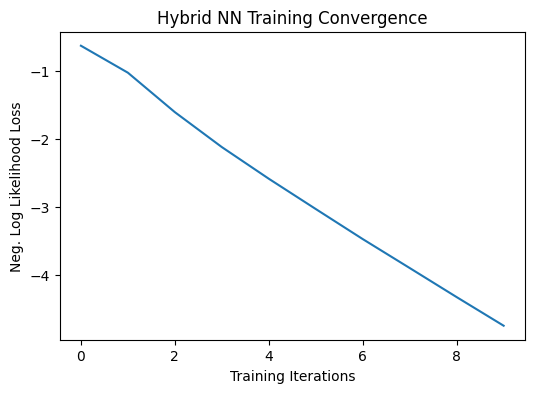

In [17]:
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

## Final Results

In [18]:
model.eval()  # set model to evaluation mode
with torch.no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )



Performance on test data:
	Loss: -4.7067
	Accuracy: 94.7%


Much better and comparable too! As it stands, quantum machine learning and quantum computing in gerenal is mostly effective at describing really specific datasets and problems, which may not be condisive to learning about a datadet, however, in the realm of hybrid QNN with classical components, it may have usage, even for more complex data.